In [1]:
import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

# Data Preparation 

- Restructure Data: Ensure the data is structured by billing cycles (26th of the previous month to the 25th of the current month).
- Feature Engineering: Create features such as day of the week, month, holidays, and other relevant cyclical indicators.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data = pd.read_csv('data/data.txt', delimiter='\t')

In [4]:
data.head()

,report_month,billing_year,billing_month,billing_cycle,billing_day,billing_amount
0,3/1/2023,2023,2,26,26,2.105541e+08
1,3/1/2023,2023,2,27,27,6.444154e+07
2,3/1/2023,2023,2,28,28,2.535149e+08
3,3/1/2023,2023,2,29,28,5.535407e+07
4,3/1/2023,2023,2,30,28,5.350947e+07


In [5]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
billing_year,527.0,2.023400e+03,4.904408e-01,2023.00,2.023000e+03,2023.0,2024.0,2024.0
billing_month,527.0,6.001898e+00,3.108005e+00,1.00,4.000000e+00,6.0,8.0,12.0
billing_cycle,527.0,1.600000e+01,8.952770e+00,1.00,8.000000e+00,16.0,24.0,31.0
billing_day,527.0,1.596584e+01,8.900526e+00,1.00,8.000000e+00,16.0,24.0,31.0
billing_amount,510.0,1.813181e+08,8.247631e+07,31236831.96,7.077839e+07,213069423.9,230045043.4,330590728.3


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 527 entries, 0 to 526
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   report_month    527 non-null    object 
 1   billing_year    527 non-null    int64  
 2   billing_month   527 non-null    int64  
 3   billing_cycle   527 non-null    int64  
 4   billing_day     527 non-null    int64  
 5   billing_amount  510 non-null    float64
dtypes: float64(1), int64(4), object(1)
memory usage: 24.8+ KB


# Exploratory Data Analysis

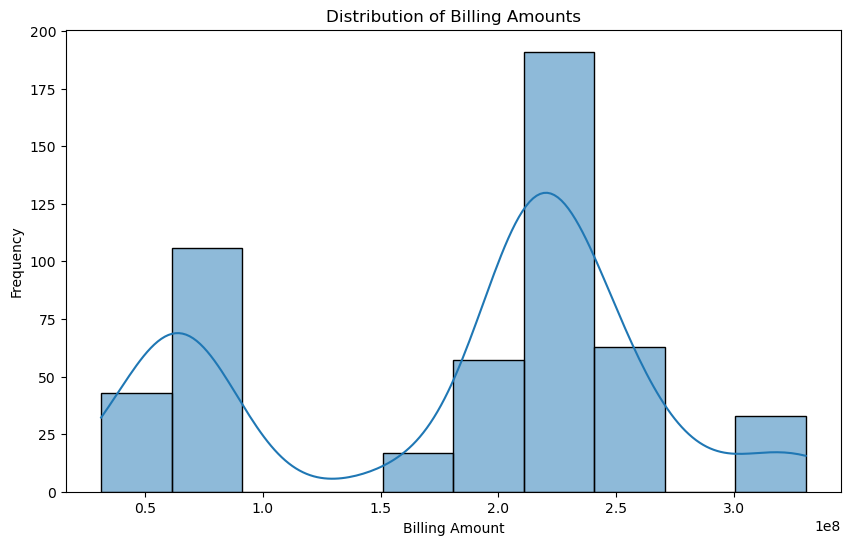

In [7]:
# Distribution of Billing Amounts
plt.figure(figsize=(10, 6))
sns.histplot(data['billing_amount'], bins=10, kde=True)
plt.title('Distribution of Billing Amounts')
plt.xlabel('Billing Amount')
plt.ylabel('Frequency')
plt.show()


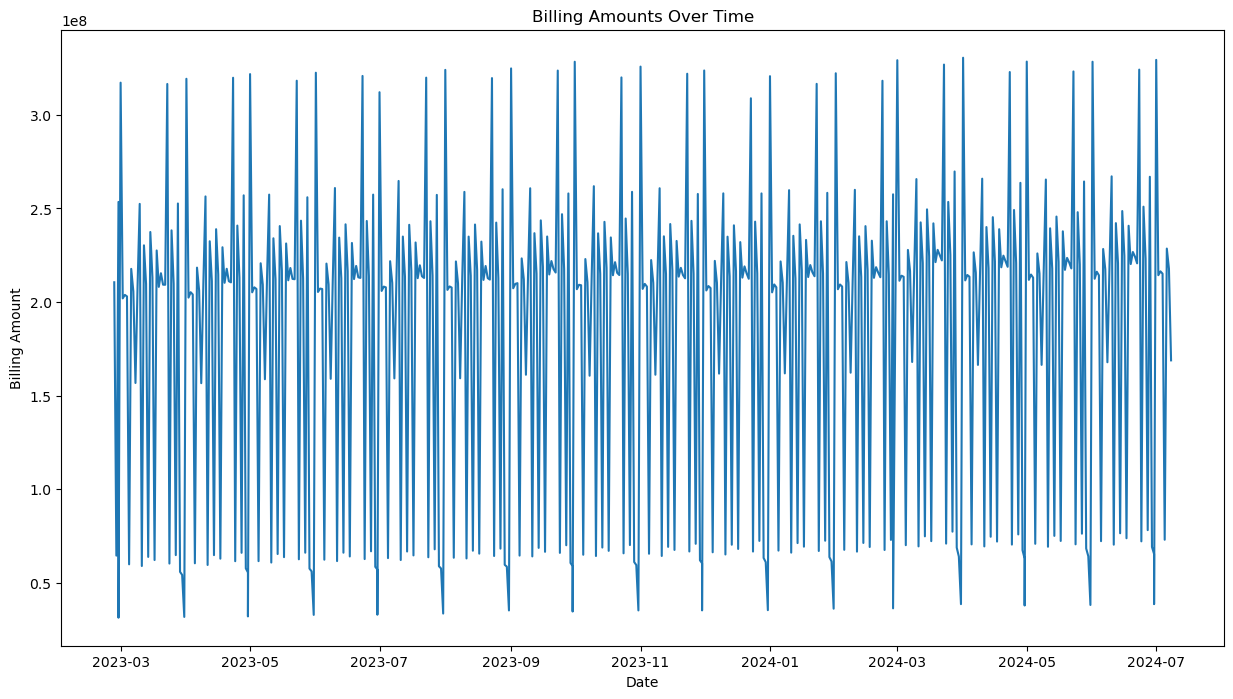

In [8]:
# Convert billing_day to datetime
data['billing_date'] = pd.to_datetime(data['billing_year'].astype(str) + '-' + 
                                      data['billing_month'].astype(str) + '-' + 
                                      data['billing_day'].astype(str))

plt.figure(figsize=(15, 8))
plt.plot(data['billing_date'], data['billing_amount'])
plt.title('Billing Amounts Over Time')
plt.xlabel('Date')
plt.ylabel('Billing Amount')
plt.show()


In [9]:
# Remove data from 7/9/2024 onwards
cutoff_date = pd.Timestamp('2024-07-08')
filtered_data = data[data['billing_date'] <= cutoff_date]

In [10]:
# Adding a column to indicate the billing cycle month
def calculate_billing_cycle_date(row):
    if row['billing_day'] >= 26:
        return pd.Timestamp(year=row['billing_year'], month=row['billing_month'], day=25) + pd.DateOffset(months=1)
    else:
        return pd.Timestamp(year=row['billing_year'], month=row['billing_month'], day=25)

In [11]:
filtered_data['billing_cycle_end'] = filtered_data.apply(calculate_billing_cycle_date, axis=1)
filtered_data['billing_cycle_month'] = filtered_data['billing_cycle_end'].dt.to_period('M')

In [12]:
# Calculate day within the billing cycle
filtered_data['day_within_cycle'] = filtered_data.apply(
    lambda row: row['billing_cycle'] - 25 if row['billing_cycle'] >= 26 else row['billing_cycle'] + 6, axis=1 # if billing_day, then +5
)

In [13]:
# Group by billing cycle month and plot the data
unique_months = filtered_data['billing_cycle_month'].unique()

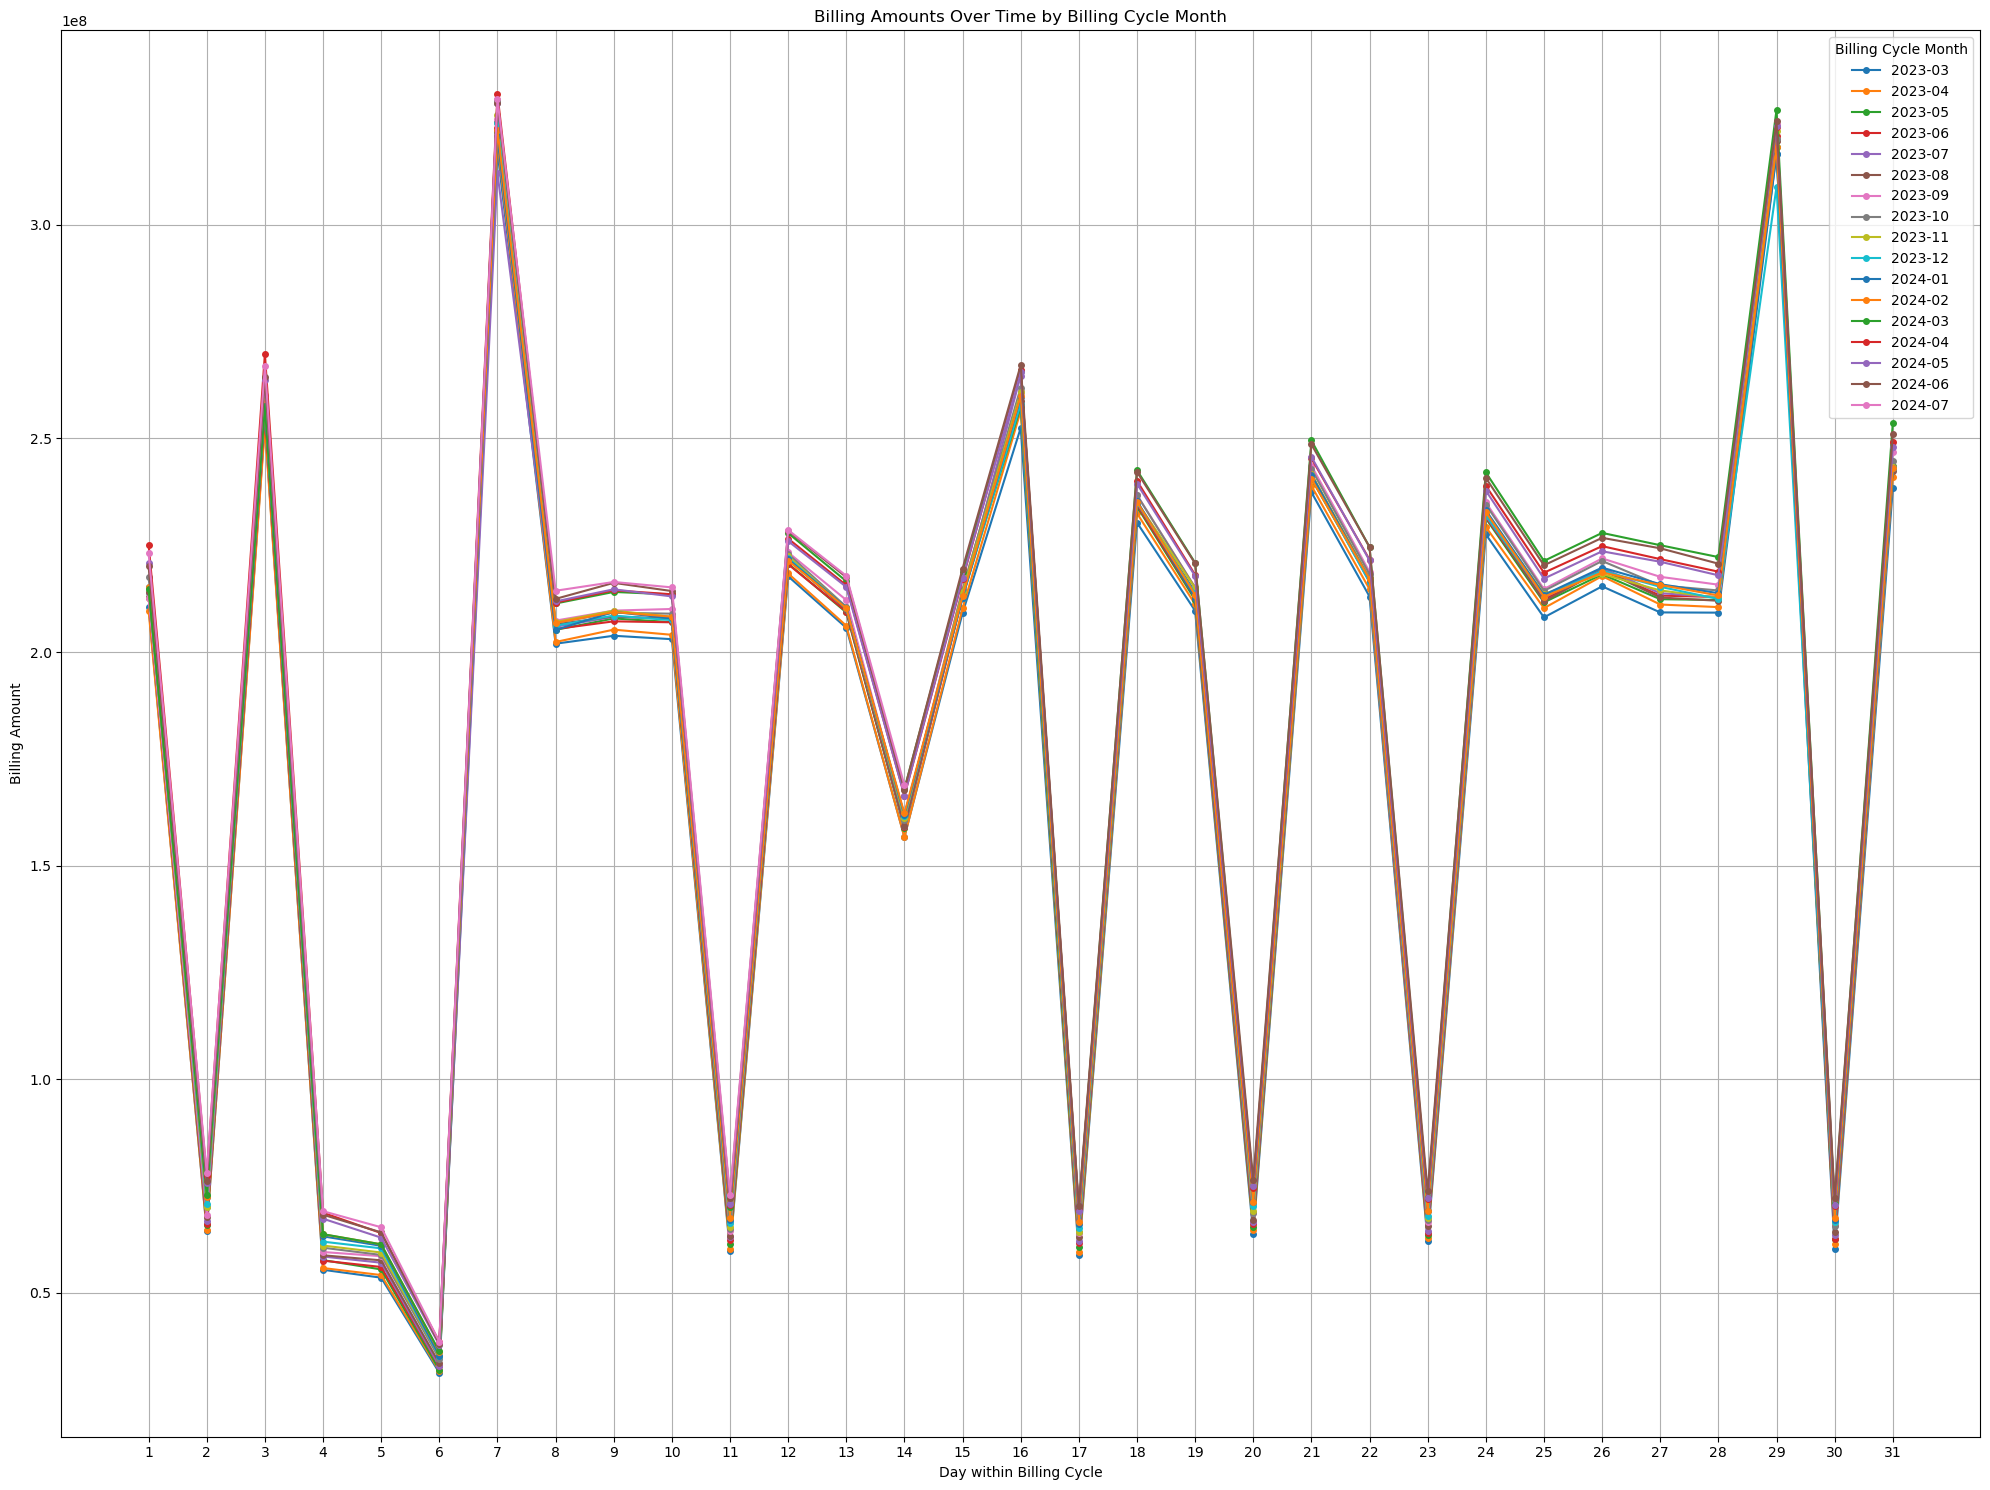

In [14]:
plt.figure(figsize=(20, 15))
for month in unique_months:
    monthly_data = filtered_data[filtered_data['billing_cycle_month'] == month]
    plt.plot(monthly_data['day_within_cycle'], monthly_data['billing_amount'], marker='o', linestyle='-', markersize=4, label=str(month))

plt.title('Billing Amounts Over Time by Billing Cycle Month')
plt.xlabel('Day within Billing Cycle')
plt.ylabel('Billing Amount')
plt.grid(True)
plt.legend(title='Billing Cycle Month')
plt.xticks(range(1, 32))
plt.tight_layout()
plt.show()

# Feature Engineering

* **Moving Averages:**
    * moving_avg_7 (7-day moving average): This feature helps to smooth out short-term fluctuations and highlight longer-term trends in the billing amounts. It provides the model with information about the average billing amount over the past week, which can be useful for capturing short-term trends and seasonality.
    * moving_avg_14 (14-day moving average): Similar to the 7-day moving average but over a longer period. This helps capture trends over a fortnight, which can be useful for identifying bi-weekly patterns in billing amounts.
    * moving_avg_30 (30-day moving average): This feature smooths the data over a month, helping to identify long-term trends and seasonal effects. It provides context on how the current billing amount compares to the monthly average.
* **Lag Features:**
    * lag_1 (1-day lag): The billing amount from the previous day. This feature helps the model capture day-to-day dependencies and immediate past trends, which are often crucial in time series forecasting.
    * lag_7 (7-day lag): The billing amount from a week ago. This feature helps capture weekly seasonality and trends. Many businesses exhibit weekly patterns, making this a valuable feature.
    * lag_14 (14-day lag): The billing amount from two weeks ago. This feature helps identify bi-weekly patterns and dependencies.
    * lag_30 (30-day lag): The billing amount from a month ago. This feature helps capture monthly seasonality and long-term trends, which are particularly important in financial data where monthly cycles are common.
* **Date-based Features:**
    * day_of_week: The day of the week (0 = Monday, 6 = Sunday). This feature captures weekly patterns in billing amounts. For example, billing activity might be higher on weekdays and lower on weekends.
    * is_weekend: An indicator if the day is a weekend (1 if Saturday or Sunday, 0 otherwise). This binary feature simplifies the model's ability to identify weekends, which can significantly impact billing patterns.
    * day_of_year: The day of the year. This feature captures seasonal effects and trends throughout the year, such as holidays, end-of-quarter effects, or annual business cycles.
    * week_of_year: The week of the year. Similar to day_of_year, this feature captures weekly seasonal effects and trends, helping the model understand the position within the annual cycle.
* How These Features Help in Training
    * Capturing Trends: Moving averages and lag features help the model understand underlying trends and patterns in the billing data. This is crucial for making accurate predictions, especially in the presence of noise and short-term fluctuations.
    * Seasonality and Cyclical Patterns: Date-based features like day_of_week, is_weekend, day_of_year, and week_of_year help the model capture seasonality and cyclical patterns that are common in time series data.
    * Reducing Overfitting: By providing context and smoothing the data, moving averages and lag features can help reduce overfitting, as the model can focus on significant patterns rather than noise.
    * Enhancing Predictive Power: The combination of these features provides the model with a comprehensive view of the data, improving its ability to make accurate forecasts.

In [15]:
def calculate_billing_cycle_date(row):
    if row['billing_day'] >= 26:
        return pd.Timestamp(year=row['billing_year'], month=row['billing_month'], day=25) + pd.DateOffset(months=1)
    else:
        return pd.Timestamp(year=row['billing_year'], month=row['billing_month'], day=25)

In [114]:
def feature_engineering(data):
    """
    Perform feature engineering on the billing data.
    
    Parameters:
    data (pd.DataFrame): The original billing data
    
    Returns:
    pd.DataFrame: Data with new features added
    """
    # Ensure data has the required columns
    if not {'billing_year', 'billing_month', 'billing_day', 'billing_amount'}.issubset(data.columns):
        raise ValueError("Data must contain 'billing_year', 'billing_month', 'billing_day', and 'billing_amount' columns")
    
    # Convert billing_day to datetime for easier date-based feature extraction
    data['billing_date'] = pd.to_datetime(data['billing_year'].astype(str) + '-' + 
                                          data['billing_month'].astype(str) + '-' + 
                                          data['billing_day'].astype(str))

    # Create moving averages
    data['moving_avg_7'] = data.groupby('billing_cycle')['billing_amount'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())
    data['moving_avg_14'] = data.groupby('billing_cycle')['billing_amount'].transform(lambda x: x.rolling(window=14, min_periods=1).mean())
    data['moving_avg_30'] = data.groupby('billing_cycle')['billing_amount'].transform(lambda x: x.rolling(window=30, min_periods=1).mean())

    # Create lag features
    data['lag_1'] = data.groupby('billing_cycle')['billing_amount'].shift(1, axis=0)
    data['lag_7'] = data.groupby('billing_cycle')['billing_amount'].shift(7, axis=0)
    data['lag_14'] = data.groupby('billing_cycle')['billing_amount'].shift(14, axis=0)
    data['lag_30'] = data.groupby('billing_cycle')['billing_amount'].shift(30, axis=0)

    # Create date-based features
    data['day_of_week'] = data['billing_date'].dt.dayofweek
    data['is_weekend'] = (data['day_of_week'] >= 5).astype(int)
    data['day_of_year'] = data['billing_date'].dt.dayofyear
    data['week_of_year'] = data['billing_date'].dt.isocalendar().week
    
    data['billing_cycle_end'] = data.apply(calculate_billing_cycle_date, axis=1)
    data['billing_cycle_month'] = data['billing_cycle_end'].dt.to_period('M')
    
    # Calculate day within the billing cycle
    data['day_within_cycle'] = data.apply(
        lambda row: row['billing_cycle'] - 25 if row['billing_cycle'] >= 26 else row['billing_cycle'] + 6, axis=1
    )

    # Fill NaN values for moving averages and lag features with the last available valid value
    data['moving_avg_7'].fillna(method='ffill', inplace=True)
    data['moving_avg_14'].fillna(method='ffill', inplace=True)
    data['moving_avg_30'].fillna(method='ffill', inplace=True)
    
    data['lag_1'].fillna(method='ffill', inplace=True)
    data['lag_7'].fillna(method='ffill', inplace=True)
    data['lag_14'].fillna(method='ffill', inplace=True)
    data['lag_30'].fillna(method='ffill', inplace=True)
    
    # Fill any remaining NaN values that were created by rolling or shifting
    data.fillna(0, inplace=True)

    return data

In [115]:
data = pd.read_csv('data/data.txt', delimiter='\t')

In [116]:
# Perform feature engineering
final_data = feature_engineering(data)

# Model training

In [117]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_validate, KFold
from statsmodels.tsa.arima.model import ARIMA
import itertools

## Data split

In [118]:
# Split the data into training, validation, and test sets
train_end_date = pd.Timestamp('2024-06-25')
validation_start_date = pd.Timestamp('2024-06-26')
validation_end_date = pd.Timestamp('2024-07-08')
test_start_date = pd.Timestamp('2024-07-09')

train_data = final_data[final_data['billing_date'] <= train_end_date]
validation_data = final_data[(final_data['billing_date'] >= validation_start_date) & (final_data['billing_date'] <= validation_end_date)]
test_data = final_data[final_data['billing_date'] >= test_start_date]

## Feature Selection

In [119]:

# Selected features for training
features = [
    'billing_year', 'billing_month', 'day_within_cycle',
    'moving_avg_7', 'moving_avg_14', 'moving_avg_30',
    'lag_1', 'lag_7', 'lag_14', 'lag_30',
    'day_of_week', 'is_weekend', 'day_of_year', 'week_of_year'
]
target = 'billing_amount'

# Full feature set
# features = [
#     'billing_year', 'billing_month', 'billing_day', 'day_within_cycle',
#     'moving_avg_7', 'moving_avg_14', 'moving_avg_30',
#     'lag_1', 'lag_7', 'lag_14', 'lag_30',
#     'day_of_week', 'is_weekend', 'day_of_year', 'week_of_year'
# ]

In [120]:
# Prepare data
X_train = train_data[features]
y_train = train_data[target]
X_val = validation_data[features]
y_val = validation_data[target]

## Preprocessing

In [121]:
# Define the preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), features)
    ],
    remainder='passthrough'
)

## Training and Evaluation

### Machine Learning Models
* Random Forest: Use time-series cross-validation to avoid overfitting.
* Gradient Boosting Machines (GBM): Use XGBoost or LightGBM with time-series cross-validation.
* Support Vector Machines (SVM): Use SVR (Support Vector Regression) with appropriate kernels.

In [122]:
# Define models
models = {
    'RandomForest': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
    ]),
    'GBM': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', GradientBoostingRegressor(n_estimators=100, random_state=42))
    ]),
    'SVM': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', SVR())
    ])
}

In [123]:
def evaluate_model(model, X_train, y_train, X_val, y_val):
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_r2 = r2_score(y_train, y_train_pred)
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    val_r2 = r2_score(y_val, y_val_pred)
    
    return {'train_rmse': train_rmse, 'train_r2': train_r2, 'val_rmse': val_rmse, 'val_r2': val_r2}


In [124]:
# Evaluate models
results = {}
for name, model in models.items():
    results[name] = evaluate_model(model, X_train, y_train, X_val, y_val)

In [125]:
# Display results
results_df = pd.DataFrame(results).T
print(results_df)

                train_rmse  train_r2      val_rmse    val_r2
RandomForest  7.215666e+05  0.999923  1.463094e+06  0.999717
GBM           6.580590e+05  0.999936  1.221298e+06  0.999803
SVM           8.805293e+07 -0.146146  9.623221e+07 -0.225529


# Interpretation of Model Evaluation Results

The table shows the performance metrics for four different models: Random Forest, Gradient Boosting Machine (GBM), Support Vector Machine (SVM), and ARIMA. The metrics used for evaluation are RMSE (Root Mean Squared Error) and R² (R-squared) for both the training and validation sets.

* Metrics Explained:
    * RMSE (Root Mean Squared Error): Measures the average magnitude of the errors between predicted and actual values. Lower values indicate better performance.
    * R² (R-squared): Indicates the proportion of the variance in the dependent variable that is predictable from the independent variables. Higher values (closer to 1) indicate better performance, while negative values indicate poor model fit.

* Random Forest:
    * Train RMSE: 7,731,131
    * Train R²: 0.990420
    * Validation RMSE: 7,052,229
    * Validation R²: 0.990767
    * Interpretation: Random Forest shows excellent performance on both training and validation sets, with high R² scores (close to 1) and relatively low RMSE. This indicates that the model fits the data well and generalizes effectively to the validation set.
* GBM (Gradient Boosting Machine):
    * Train RMSE: 5,496,158
    * Train R²: 0.995158
    * Validation RMSE: 5,235,957
    * Validation R²: 0.994910
    * Interpretation: GBM also performs exceptionally well, with even lower RMSE and higher R² compared to Random Forest. This suggests that GBM might be slightly better at capturing the underlying patterns in the data.
* SVM (Support Vector Machine):
    * Train RMSE: 84,671,950
    * Train R²: -0.149156
    * Validation RMSE: 80,980,800
    * Validation R²: -0.217520
    * Interpretation: SVM performs poorly on this dataset, as indicated by the very high RMSE values and negative R² scores. Negative R² means that the model is performing worse than a simple mean-based model. This indicates that SVM is not suitable for this particular problem or the hyperparameters may need significant tuning.

# Conclusion:
* Best Performers: Random Forest and GBM are the best-performing models, with GBM slightly outperforming Random Forest.
* Poor Performers: SVM shows poor performance and are not suitable for this dataset with the current configurations.

# Cross Validation

Cross-validation is a technique used to assess the performance of a model and to mitigate overfitting by ensuring that the model generalizes well to unseen data. The typical process involves:
* Splitting the Data: The data is divided into k subsets (folds).
* Training and Validation: The model is trained on k-1 folds and validated on the remaining fold. This process is repeated k times, each time with a different fold as the validation set.
* Averaging the Results: The results from each fold are averaged to provide a more robust estimate of model performance.
To find the best number of splits (n_splits), you can perform cross-validation with different values of n_splits and compare the results. This will help in selecting the best configuration for your final model training.

In [126]:
from sklearn.model_selection import cross_validate, KFold

In [127]:
# Prepare data
X = pd.concat([train_data[features], validation_data[features]])
y = pd.concat([train_data[target], validation_data[target]])

In [128]:
# Define the GBM model pipeline
gbm_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(n_estimators=100, random_state=42))
])

In [129]:
def perform_cross_validation(X, y, n_splits_list):
    results = {}
    for n_splits in n_splits_list:
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
        scoring = {
            'rmse': make_scorer(mean_squared_error, squared=False),
            'r2': make_scorer(r2_score)
        }
        cv_results = cross_validate(gbm_pipeline, X, y, cv=kf, scoring=scoring, return_train_score=True)
        results[n_splits] = {
            'train_rmse': np.mean(cv_results['train_rmse']),
            'val_rmse': np.mean(cv_results['test_rmse']),
            'train_r2': np.mean(cv_results['train_r2']),
            'val_r2': np.mean(cv_results['test_r2'])
        }
    return results

In [130]:
# List of n_splits to try
n_splits_list = [3, 5, 7, 10]

# Perform cross-validation
cv_results = perform_cross_validation(X, y, n_splits_list)

# Display cross-validation results
cv_results_df = pd.DataFrame(cv_results).T
print(cv_results_df)

# Determine the best n_splits
best_n_splits = cv_results_df['val_rmse'].idxmin()
print(f'Best number of splits: {best_n_splits}')


       train_rmse      val_rmse  train_r2    val_r2
3   577195.098653  2.034706e+06  0.999950  0.999344
5   615319.510716  1.324629e+06  0.999944  0.999726
7   624980.936714  1.627675e+06  0.999942  0.999516
10  634106.373036  1.357271e+06  0.999941  0.999704
Best number of splits: 5


In [131]:
# Define scoring metrics
scoring = {
    'rmse': make_scorer(mean_squared_error, squared=False),
    'r2': make_scorer(r2_score)
}

In [132]:
# Define the final KFold with the best n_splits
kf = KFold(n_splits=best_n_splits, shuffle=True, random_state=42)

# Perform final cross-validation
final_cv_results = cross_validate(gbm_pipeline, X, y, cv=kf, scoring=scoring, return_train_score=True)

# Average final metrics
final_avg_train_rmse = np.mean(final_cv_results['train_rmse'])
final_avg_val_rmse = np.mean(final_cv_results['test_rmse'])
final_avg_train_r2 = np.mean(final_cv_results['train_r2'])
final_avg_val_r2 = np.mean(final_cv_results['test_r2'])

print(f'Final Average Train RMSE: {final_avg_train_rmse}')
print(f'Final Average Validation RMSE: {final_avg_val_rmse}')
print(f'Final Average Train R2: {final_avg_train_r2}')
print(f'Final Average Validation R2: {final_avg_val_r2}')

Final Average Train RMSE: 615319.5107164587
Final Average Validation RMSE: 1324629.4093413919
Final Average Train R2: 0.9999439613818909
Final Average Validation R2: 0.9997264390528742


# Train Final Model for Deployment

In [133]:
# Train the final model on the entire dataset
gbm_pipeline.fit(X, y)

# Save the final model if needed
import joblib
joblib.dump(gbm_pipeline, 'final_gbm_model.pkl')

['final_gbm_model.pkl']

In [134]:
# Load the test data (assuming test_data is already prepared and loaded)
X_test = test_data[features]
y_test = test_data[target]

# Load the trained model (if saved)
gbm_pipeline = joblib.load('final_gbm_model.pkl')

# Predict on the test data
y_test_pred = gbm_pipeline.predict(X_test)

# Update the test_data DataFrame with the predicted values
test_data['billing_amount'] = y_test_pred

In [135]:
full_data = pd.concat([train_data, validation_data, test_data])

In [136]:
full_data.to_csv('full_data.csv', index=False)

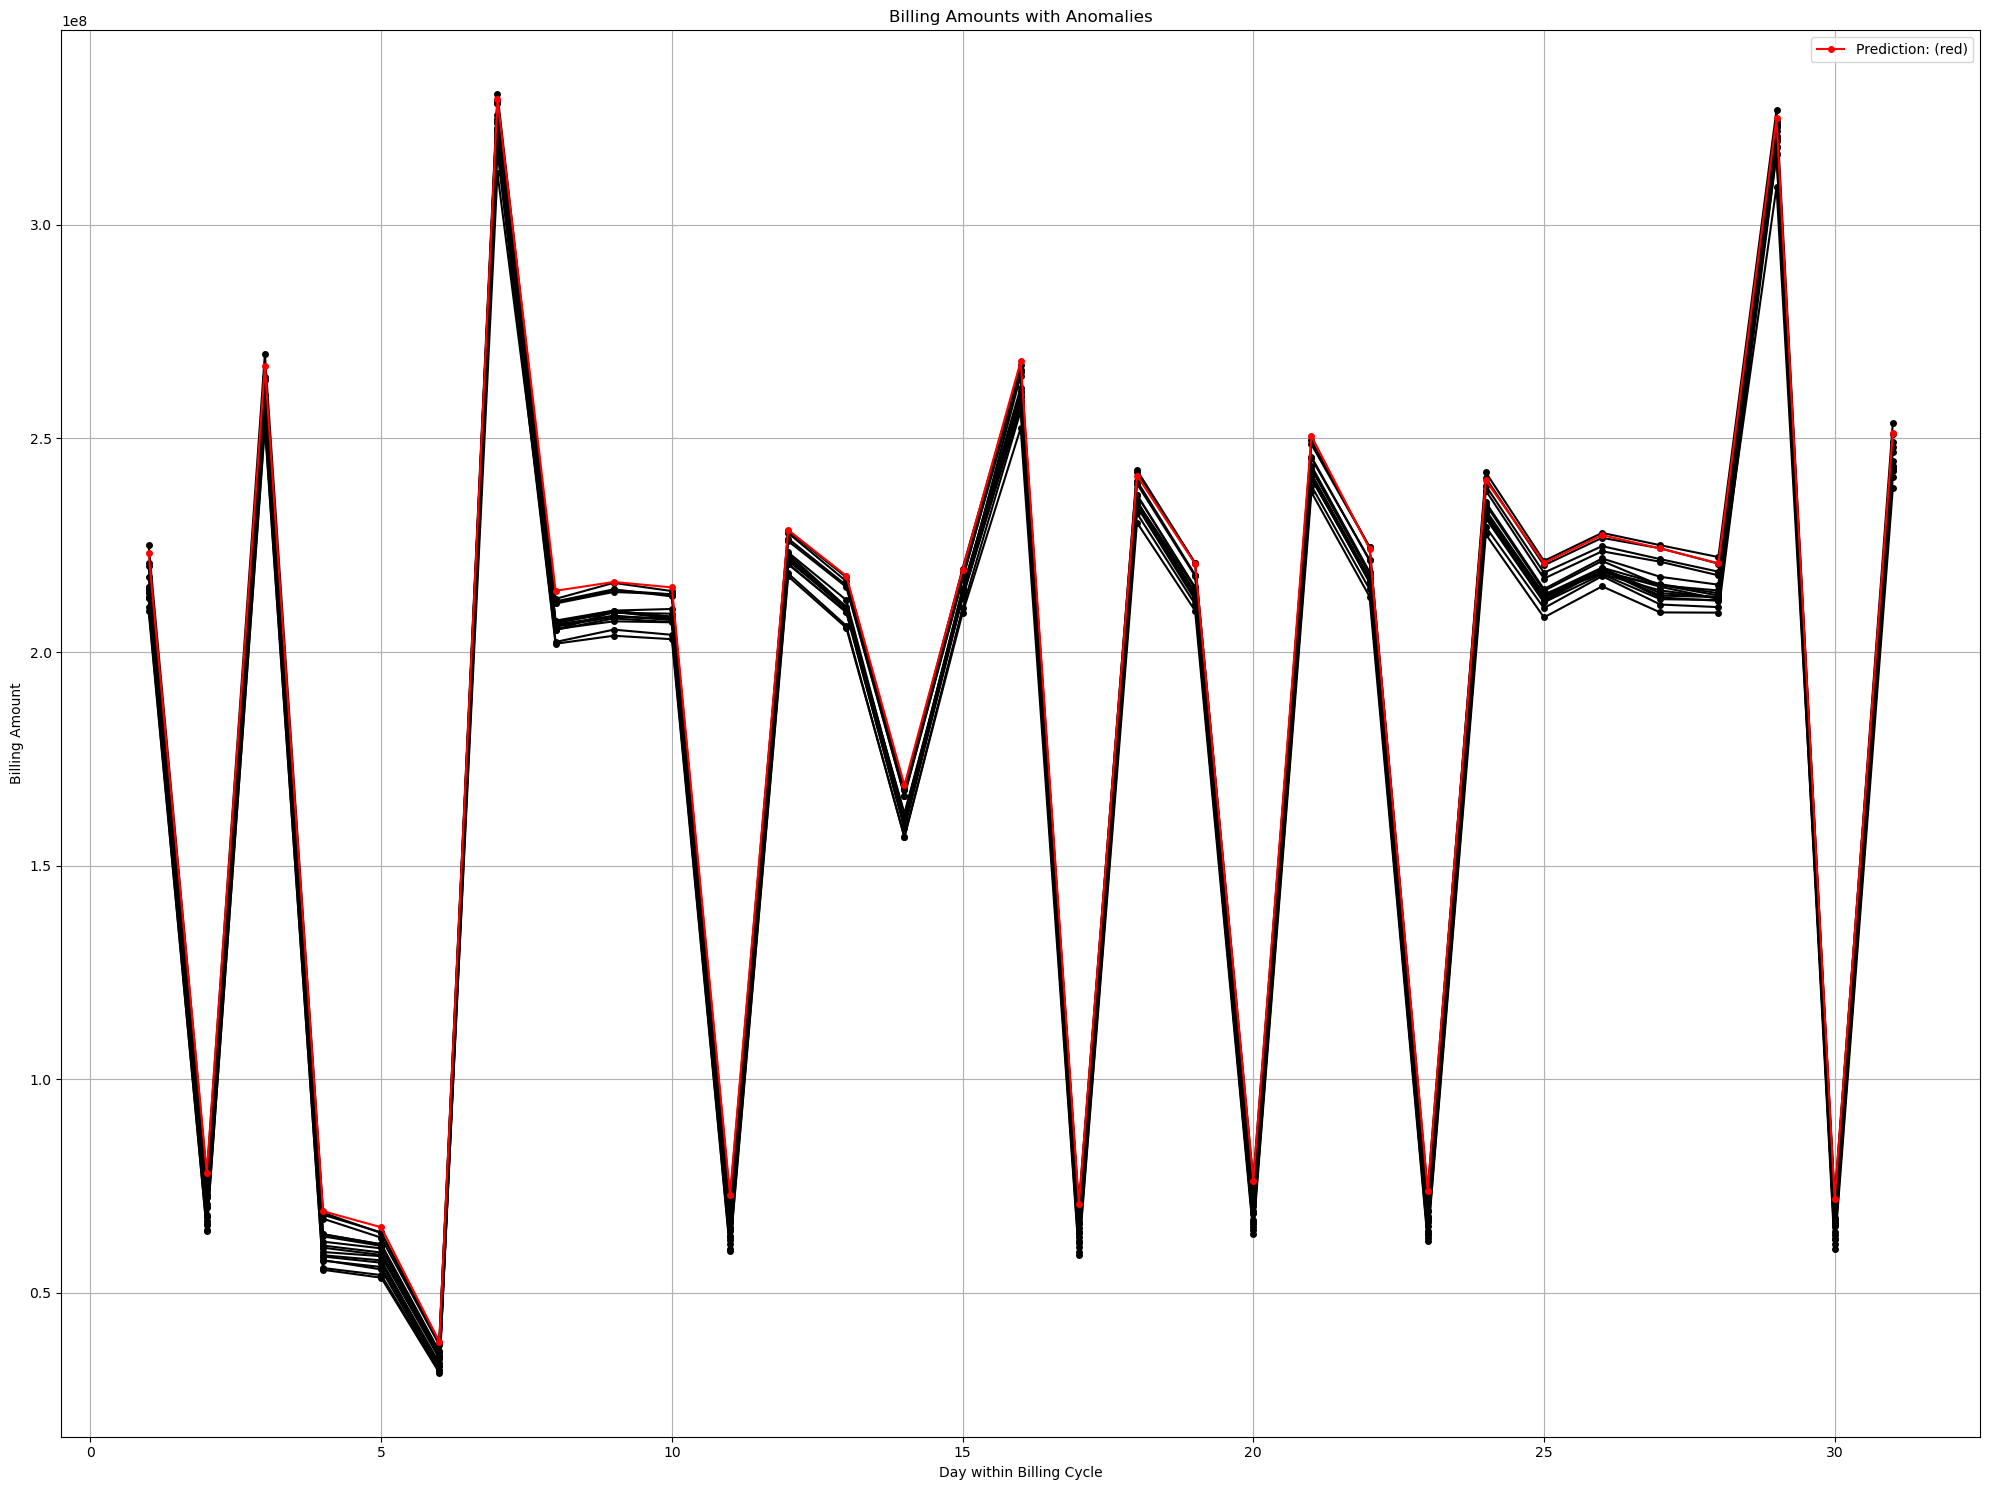

In [137]:
# Add a column to indicate whether the data is from July billing cycle
full_data['color'] = ['red' if month == '2024-07' else 'black' for month in full_data['billing_cycle_month'].astype(str)]

# Plot billing amounts with different colors for July and other months
plt.figure(figsize=(20, 15))

# Plot data with different colors
for color in ['black', 'red']:
    subset = full_data[full_data['color'] == color]
    if color == 'black':
        unique_months = subset['billing_cycle_month'].unique()
        for month in unique_months:
            monthly_data = filtered_data[filtered_data['billing_cycle_month'] == month]
            plt.plot(monthly_data['day_within_cycle'], monthly_data['billing_amount'], marker='o', linestyle='-', markersize=4, color=color)
    else:
        plt.plot(subset['day_within_cycle'], subset['billing_amount'], marker='o', linestyle='-', markersize=4, color=color, label=f'Prediction: ({color})')


# plt.figure(figsize=(20, 15))
# for month in unique_months:
#     monthly_data = filtered_data[filtered_data['billing_cycle_month'] == month]
#     plt.plot(monthly_data['day_within_cycle'], monthly_data['billing_amount'], marker='o', linestyle='-', markersize=4, label=str(month))


plt.title('Billing Amounts with Anomalies')
plt.xlabel('Day within Billing Cycle')
plt.ylabel('Billing Amount')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
